### Part 2: Calculating the F-F curve of DPI neurons

In the second part, we will calculate the F-F curve of silicon neurons. In neuroscience, the F-F curve is a function that relates to the input firing rate and the output firing rate of a neuron. Because the F-F curve only specifies the firing rate rather than exact spike times, it is a concept suited to the rate coding rather than the temporal coding model of neuronal computation. To obtain the F-F curve, we will simulate silicon neurons with a range of spike frequencies and observe the output behavior.

In [1]:
from brian2 import *
from DynapSE import DynapSE
from equations.dynapse_eq import *
from parameters.dynapse_param import *
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline 
mpl.rcParams['figure.dpi'] = 90  
set_device('cpp_standalone')

There are multiple ways to create spike trains of different frequencies and stimulate neurons. One way is to stimulate single neuron with a fixed frequency and loop over a set of frequencies. Alternatively, we can stimulate multiple neurons, each with unique frequency in parallel. The latter is more compute-efficient on Brian2, and this is what we are going to implement.

In [2]:
## Calculating the F-F curve of DPI neurons
##################
# TODO: 
# - Play with frequency range and the simulation duration
# 
# Parameters
inp_duration   = 5     # second - Simulation duration (default: 5)
freq_start     = 0     # Hz - Starting frequency (Neuron 0 will be stimulated with this Poisson rate) (default: 0)
freq_stop      = 200   # Hz - Stop frequency (The last neuron will be stimulated with this Poisson rate) (default: 200)
##################

device.reinit()
device.activate()
defaultclock.dt = 20 * us
# Ignore Brian2 base warnings
BrianLogger.suppress_name('base')

# Create a Brian2 network and chip instance using that monitors Dynap-SE1 resources.
network = Network()
chip = DynapSE(network)

To simulate neurons, we will use Poisson spikes. For stimulating $N$ neurons, we require $N$ different Poisson rates. To achieve that, we create a matrix with dimensions [simulation time steps, source ID], where the source ID represents the firing rate, e.g., source 5 will fire at 5 Hz, source 20 at 20 Hz, etc.

Then we will create our network on Brian2, similar to Part 1, except for one single difference. This time, we will connect single sources to single corresponding neurons (one-to-one instead of all-to-all). To achieve that, we use `DPI_synapse.connect(j='i')`.

In [3]:
# Create [time_steps, source ID] matrix, where firing rate is defined by source ID.
# e.g., source 5 will fire at 5 Hz.
rates2 = np.tile(np.linspace(freq_start, freq_stop, freq_stop-freq_start), (inp_duration*1000, 1)) # shape: (inp_duration*1000, 256)

# Create a TimedArray according to rate information
spike_timing = TimedArray(rates2 * Hz , dt=1 * us) 

# Using spike timing function, generate a Spike Generator that creates Poisson spikes
input_spike_generator = PoissonGroup(freq_stop-freq_start, "spike_timing(t,i)")

# Allocate neurons such that each firing frequency will be assigned to single neuron.
DPI_neuron  = chip.get_neurons(freq_stop-freq_start, 'Core_1')
DPI_synapse = chip.add_connection(input_spike_generator, DPI_neuron, synapse_type='NMDA')

# One-to-one (j=i) mapping, instead of all-to-all connection
chip.connect(DPI_synapse, j='i')
DPI_synapse.weight = 300

# Monitors
mon_neuron_input  = SpikeMonitor(input_spike_generator, name='mon_neuron_input')
mon_neuron_output = SpikeMonitor(DPI_neuron, name='mon_neuron_output')
network.add([input_spike_generator, DPI_neuron, DPI_synapse, mon_neuron_input, mon_neuron_output])

# Simulation
network.run(inp_duration * 1000 * ms)

200 neurons are allocated from Core_1.


After the simulation, we can calculate each neuron's firing rate by looking at the number of spikes it generates throughout the simulation.

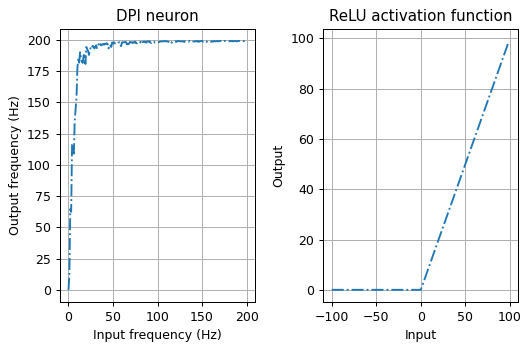

In [ ]:
plt.subplot(121)
plot(mon_neuron_output.count/ inp_duration * 1000 * ms,'-.') # Count number of spikes per neuron
plt.xlabel('Input frequency (Hz)')
plt.ylabel('Output frequency (Hz)')
plt.title(f'DPI neuron')
plt.grid(True)
plt.subplot(122)
plot(np.arange(-100,100,1),np.maximum(0,np.arange(-100,100,1)),'-.') # Implement ReLU function
plt.xlabel('Input')
plt.ylabel('Output')
plt.title(f'ReLU activation function')
plt.grid(True)
plt.tight_layout()

There are a few things to notice in the figure above. 

- Neurons did not fire until a threshold input firing rate is reached. 
- Input / Output relationship is very similar to ReLU activation function of ANNs.
- The F-F curve looks noisy. It is because of the stochastic nature of Poisson inputs. The variance can be decreased by simulating network longer.
- After threshold, it looks linear, but we do not expect firing rate to increaseforever. The firing rate saturates at some point.
- Side note: In neocortex, firing rate of neurons also saturates after large input, but neurons almost always operate on the linear part of the slope.

In [ ]:
## Calculating the FF curve of DPI
##################
# TODO: 
# - Change the parameters to observe the saturation of FF-curve. (It may depend on various factors)
# 
#
#
##################

The slope of a neuron's F-F curve depends on many factors including the time constant of its input synapses and their synaptic efficacies. In the cell below, we compared F-F curves of DPI neurons with `AMPA` and `NMDA` synapses with three different weight strengths.

In [ ]:
syn_type_list   = ['AMPA', 'NMDA']
syn_weight_list = [300, 400, 500]

spike_counts = np.zeros((6,200))
for ix, synapse_type in enumerate(syn_type_list):
    # Reinitialize the device
    device.reinit()
    device.activate()
    defaultclock.dt = 20 * us

    # Create a DynapSE instance
    network = Network()
    chip = DynapSE(network)

    # New input generator
    rates3 = np.tile(np.linspace(freq_start, freq_stop, freq_stop-freq_start), (5*1000, 1)) # shape: (inp_duration*1000, 256)
    spike_timing = TimedArray(rates3 * Hz , dt=1 * us) 
    input_spike_generator = PoissonGroup(freq_stop-freq_start, "spike_timing(t,i)")
    
    # 200 neurons from Core 0
    neurons_0  =  chip.get_neurons(freq_stop-freq_start, 'Core_0')
    synapses_0 =  chip.add_connection(input_spike_generator, neurons_0, synapse_type=synapse_type)
    chip.connect(synapses_0, j='i')
    synapses_0.weight = syn_weight_list[0]
    mon_neuron_output_0 = SpikeMonitor(neurons_0, name='mon_neuron_output_0')
    
    # 200 neurons from Core 1
    neurons_1  =  chip.get_neurons(freq_stop-freq_start, 'Core_1')
    synapses_1 =  chip.add_connection(input_spike_generator, neurons_1, synapse_type=synapse_type)
    chip.connect(synapses_1, j='i')
    synapses_1.weight = syn_weight_list[1]
    mon_neuron_output_1 = SpikeMonitor(neurons_1, name='mon_neuron_output_1')
    
    # 200 neurons from Core 2
    neurons_2  =  chip.get_neurons(freq_stop-freq_start, 'Core_2')
    synapses_2 =  chip.add_connection(input_spike_generator, neurons_2, synapse_type=synapse_type)
    chip.connect(synapses_2, j='i')
    synapses_2.weight = syn_weight_list[2]
    mon_neuron_output_2 = SpikeMonitor(neurons_2, name='mon_neuron_output_2')

    # Monitors
    network.add([input_spike_generator, neurons_0, neurons_1, neurons_2, synapses_0, synapses_1, synapses_2, mon_neuron_output_0, mon_neuron_output_1, mon_neuron_output_2])

    # Simulation
    network.run(inp_duration * 1000 * ms)
    
    # Save
    spike_counts[3*ix+0,:] = mon_neuron_output_0.count/inp_duration
    spike_counts[3*ix+1,:] = mon_neuron_output_1.count/inp_duration
    spike_counts[3*ix+2,:] = mon_neuron_output_2.count/inp_duration
    print('Reseting the chip settings ...')

200 neurons are allocated from Core_0.
200 neurons are allocated from Core_1.
200 neurons are allocated from Core_2.


INFO       Overwriting environment variable "DYLD_LIBRARY_PATH" [brian2.devices.cpp_standalone.device.overwritten_env_var]


Reseting the chip settings ...
200 neurons are allocated from Core_0.
200 neurons are allocated from Core_1.
200 neurons are allocated from Core_2.
Reseting the chip settings ...


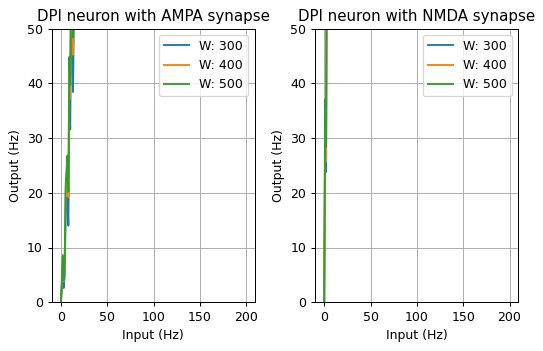

In [ ]:
# Plot the results
for i in range(2):
    plt.subplot(120+i+1)
    plt.title(f'DPI neuron with {syn_type_list[i]} synapse')
    for j in range(3):
        plt.plot(spike_counts[3*i+j], label=f'W: {syn_weight_list[j]}')
        plt.xlabel('Input (Hz)')
        plt.ylabel('Output (Hz)')
        plt.ylim([0,50])
        plt.legend()
        plt.grid()
plt.tight_layout()

This is the end of Part 2.